In [6]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM 
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 5
time_steps = 101
category = 2
max_data_size = 100000
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [3]:
file_read = open("../imgtvgene_sequence_classification/naive.txt")

source_sequence = []
target_sequence = []

cluster_tag = []
cluster_dic = {}
classes = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0
max_count = 1000000

max_source = 0
max_target = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    if not split[1] in cluster_dic:
        classes += 1
        cluster_dic[split[1]] = classes
    cluster_tag.append(split[1])
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source < len(source):
        max_source = len(source)
    
    target = [char_to_int[x] for x in split[-2][1:-1]]
    target_sequence.append(target)
    if max_target < len(target):
        max_target = len(target)
    
    vgene_name = split[-1][1:-1]#.split("*")[0]
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
source_sequence = np.array(source_sequence)
target_sequence = np.array(target_sequence)

cluster_tag = np.array(cluster_tag)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, target_sequence.shape)
print(max_source, max_target)
print()
print(cluster_tag.shape, vgene_tag.shape)
print(classes, vgenes)


(1000000,) (1000000,)
526 207

(1000000,) (1000000,)
203966 213


In [4]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

x_data = pad_sequences(source_sequence, maxlen=max_source, value=0)
y_data = to_categorical(vgene_tag)

train_index = int((len(x_data) / batch_size) * 0.60 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (600000, 800000, 1000000)
(600000, 526) (600000, 213)
(200000, 526) (200000, 213)
(200000, 526) (200000, 213)


In [19]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

input_source = Input(shape=(max_source,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source, \
                      name='embedding')(input_source)

lstm_layer = LSTM(5, return_sequences=True)(embedding)
lstm_layer = Dropout(0.25)(lstm_layer)
reshape_layer = Reshape((max_source*5,))(lstm_layer)

dense_layer_first = Dense(1024, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
embedding (Embedding)        (None, 526, 5)            30        
_________________________________________________________________
lstm_9 (LSTM)                (None, 526, 5)            220       
_________________________________________________________________
dropout_29 (Dropout)         (None, 526, 5)            0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 2630)              0         
_________________________________________________________________
fstlayer (Dense)             (None, 1024)              2694144   
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
__________

In [20]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=20, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 600000 samples, validate on 200000 samples
Epoch 1/20



Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/moamin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/moamin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/moamin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 - 466s - loss: 1.5244 - acc: 0.6104 - val_loss: 0.4381 - val_acc: 0.8823
Epoch 2/20
 - 458s - loss: 0.4256 - acc: 0.8742 - val_loss: 0.3274 - val_acc: 0.9044
Epoch 3/20
 - 466s - loss: 0.3283 - acc: 0.9044 - val_loss: 0.2970 - val_acc: 0.9162
Epoch 4/20
 - 462s - loss: 0.2758 - acc: 0.9205 - val_loss: 0.2546 - val_acc: 0.9221
Epoch 5/20
 - 467s - loss: 0.2388 - acc: 0.9313 - val_loss: 0.2471 - val_acc: 0.9275
Epoch 6/20
 - 466s - loss: 0.2112 - acc: 0.9402 - val_loss: 0.2007 - val_acc: 0.9454
Epoch 7/20
 - 447s - loss: 0.1854 - acc: 0.9488 - val_loss: 0.1591 - val_acc: 0.9540
Epoch 8/20
 - 407s - loss: 0.1677 - acc: 0.9546 - val_loss: 0.1617 - val_acc: 0.9629
Epoch 9/20
 - 406s - loss: 0.1538 - acc: 0.9586 - val_loss: 0.1417 - val_acc: 0.9595
Epoch 10/20
 - 406s - loss: 0.1444 - acc: 0.9613 - val_loss: 0.1273 - val_acc: 0.9644
Epoch 11/20
 - 405s - loss: 0.1333 - acc: 0.9641 - val_loss: 0.1424 - val_acc: 0.9663
Epoch 12/20
 - 405s - loss: 0.1263 - acc: 0.9663 - val_loss: 0.1135 - val_

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


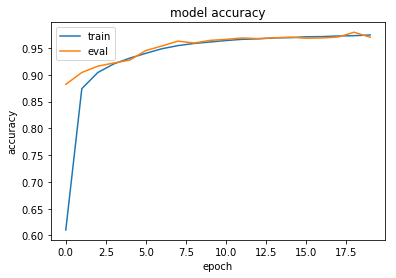

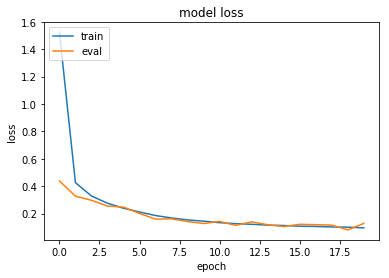

In [21]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Simple Layer

In [10]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

input_source = Input(shape=(max_source,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source, \
                      name='embedding')(input_source)

reshape_layer = Reshape((max_source*embedding_size,))(embedding)
dense_layer_first = Dense(1024, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
embedding (Embedding)        (None, 526, 5)            30        
_________________________________________________________________
reshape_2 (Reshape)          (None, 2630)              0         
_________________________________________________________________
fstlayer (Dense)             (None, 1024)              2694144   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
midlayer (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [11]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=20, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 600000 samples, validate on 200000 samples
Epoch 1/20
 - 88s - loss: 1.3643 - acc: 0.6373 - val_loss: 0.4119 - val_acc: 0.8561
Epoch 2/20
 - 87s - loss: 0.3632 - acc: 0.8804 - val_loss: 0.2970 - val_acc: 0.8916
Epoch 3/20
 - 86s - loss: 0.2622 - acc: 0.9135 - val_loss: 0.2218 - val_acc: 0.9196
Epoch 4/20
 - 86s - loss: 0.2094 - acc: 0.9320 - val_loss: 0.1908 - val_acc: 0.9368
Epoch 5/20
 - 86s - loss: 0.1766 - acc: 0.9430 - val_loss: 0.1691 - val_acc: 0.9454
Epoch 6/20
 - 86s - loss: 0.1562 - acc: 0.9500 - val_loss: 0.1637 - val_acc: 0.9448
Epoch 7/20
 - 86s - loss: 0.1400 - acc: 0.9551 - val_loss: 0.1374 - val_acc: 0.9597
Epoch 8/20
 - 86s - loss: 0.1281 - acc: 0.9590 - val_loss: 0.1364 - val_acc: 0.9564
Epoch 9/20
 - 86s - loss: 0.1206 - acc: 0.9617 - val_loss: 0.1353 - val_acc: 0.9587
Epoch 10/20
 - 87s - loss: 0.1128 - acc: 0.9644 - val_loss: 0.1315 - val_acc: 0.9627
Epoch 11/20
 - 86s - loss: 0.1043 - acc: 0.9675 - val_loss: 0.1277 - val_acc: 0.9654
Epoch 12/20
 

# Allele Level Classification

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


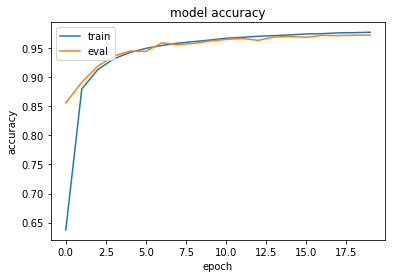

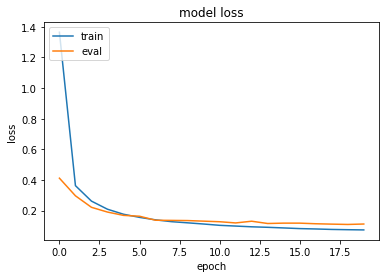

In [12]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Chromosome Level Classification

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


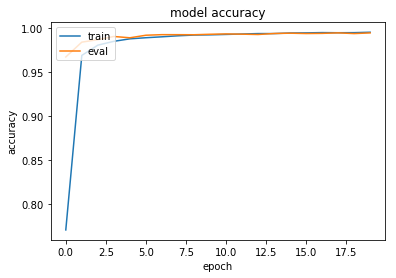

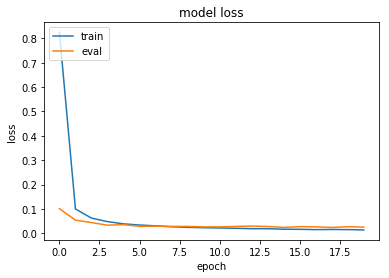

In [7]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [8]:
layer_name = "finlayer"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).get_output_at(0))
intermediate_output = intermediate_layer_model.predict(x_test)


In [ ]:
from sklearn.manifold import TSNE
st_index = int(len(intermediate_output) / 2) - 5000
end_index = st_index + 10000
twod_embeddings = TSNE(n_components=2).fit_transform(intermediate_output[:])
print(twod_embeddings.shape)